<h1><center> Estimating Friedrich's coefficients describing the deterministic dynamics of Langevin model</center></h1>

<center>Andreas W. Kempa-Liehr (Department of Engineering Science, University of Auckland)</center>

This notebooks explains the friedrich_coefficient features, which has been inspired by the paper of Friedrich et al. (2000): *Extracting model equations from experimental data*. Physics Letters A 271, p. 217-222

The general idea is to assume a Langevin model for the dynamics of the time series $x(t)$ 
$$\dot{x}(t) = h(x(t)) + \mathcal{N}(0,R)$$
with $\dot{x}(t)$ denoting the temporal derivative, $h(x(t))$ the deterministic dynamics, and $\mathcal{N}(0,R)$ a Langevin force modelled as Gaussian white noise with standard deviation $R$.
Now, an estimate $\tilde{h}(x)$ of the deterministic dynamics can be computed by averaging $\dot{x}(t)$ for a specific interval $x(t)\in[x-\epsilon,x+\epsilon]$ with $|\epsilon|\ll 1$:
$$\left.\tilde{h}(x)\right|_{x\in[x-\epsilon,x+\epsilon]} \approx \frac{\sum\limits_{x(t)\in[x-\epsilon,x+\epsilon]} x(t+\Delta_t)-x(t)}{\Delta_t \sum\limits_{x(t)\in[x-\epsilon,x+\epsilon]} 1}.$$
Having a set of estimations $\{\tilde{h}(x_1),\tilde{h}(x_2),\ldots,\tilde{h}(x_n)\}$ with $x_1<x_2<\ldots<x_n$ at hand, Friedrich's coefficients are calculated by fitting a polynomial of order $m$ to these estimates.

In order to demonstrate this approach, the dynamics of a dissipative soliton before and after its drift-bifurcation is simulated (Liehr 2013: *Dissipative Solitons in Reaction-Diffusion Systems*. Springer, p. 164).
By applying the approach of Friedrich et al. for estimating the deterministic dynamics, the equilibrium velocity of the dissipative soliton is recovered.


In [1]:
from matplotlib import pylab as plt
import numpy as np
import seaborn as sbn
import pandas as pd
from tsfresh.examples.driftbif_simulation import velocity

In [2]:
%matplotlib inline

In [3]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.feature_calculators import max_langevin_fixed_point, friedrich_coefficients
settings = ComprehensiveFCParameters()
default_params = settings['max_langevin_fixed_point'][0]
default = settings['friedrich_coefficients']

In [4]:
def friedrich_method(v, param):
    df = pd.DataFrame({'velocity': v[:-1,0], 'acceleration': np.diff(v[:,0])})
    df['quantiles']=pd.qcut(df.velocity.values, 30)
    groups = df.groupby('quantiles')
    result = pd.DataFrame({'a_mean': groups.acceleration.mean(),
                           'a_std': groups.acceleration.std(),
                           'v_mean': groups.velocity.mean(),
                           'v_std': groups.velocity.std()
                          })
    dynamics = friedrich_coefficients(v[:,0], param)
    dynamics = [d[1] for d in dynamics]
    v0 = max_langevin_fixed_point(v[:,0], **default_params)
    
    plt.subplot(2,1,1)
    plt.plot(v[:,0])
    plt.axhline(y=v0, color='r')
    plt.xlabel('time')
    plt.ylabel('velocity')

    #Active Brownian motion is given if the linear term of the dynamics is positive
    if dynamics[-2]>0:
        active='Active'
    else:
        active=''
        
    plt.title('{} Brownian Motion (largest equilibrium velocity in red)'.format(active))
    plt.subplot(2,1,2)
    ax = plt.errorbar(result.v_mean,result.a_mean,
                 xerr=result.v_std,fmt='o')
    x = np.linspace(-0.004, 0.004, 201)
    print(dynamics)
    plt.plot(x, np.poly1d(dynamics)(x), label='estimated dynamics')
    plt.plot(v0,0.,'ro')
    plt.axvline(x=v0, color='r')
    plt.xlabel('mean velocity')
    plt.ylabel('mean acceleration')

# Beyond drift-bifurcation

In [5]:
ds = velocity(tau=3.8, delta_t=0.05, R=3e-4, seed=0)
v = ds.simulate(1000000, v0=np.zeros(1))

[-343.32787387478163, 0.03745305712005136, 0.002256967951186641, -1.0236536382784505e-07]


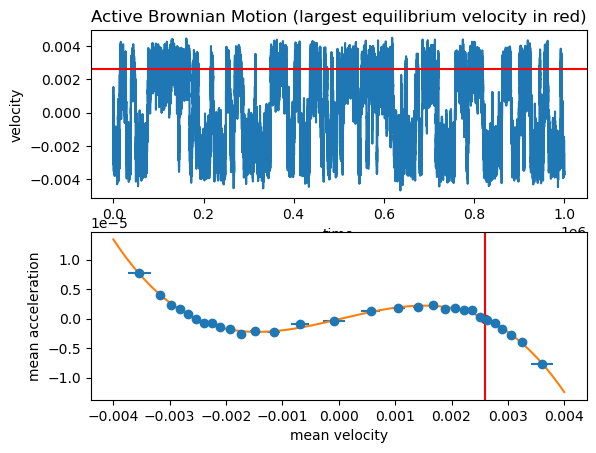

In [6]:
friedrich_method(v, default)

# Before drift-bifurcation

In [7]:
ds = velocity(tau=2./0.3-3.8, delta_t=0.05, R=3e-4, seed=0)
v = ds.simulate(1000000, v0=np.zeros(1))

[-430.6354499011763, 0.08347639306912537, -0.002023472165970792, 4.3026801890003886e-08]


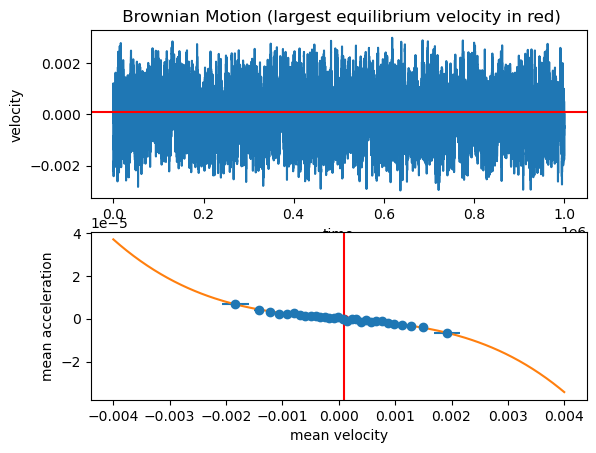

In [8]:
friedrich_method(v, default)